In [14]:
import os
from datetime import datetime, timedelta
from contextlib import contextmanager
from collections import defaultdict

import psycopg2
import matplotlib.pyplot as plt

@contextmanager
def get_cursor():
    conn = psycopg2.connect(os.environ['DATABASE_URL'])
    cur = conn.cursor()
    
    try:
        yield cur
    finally:
        cur.close()
        conn.close()
        
def transpose(rows):
    values = tuple([[] for _ in range(len(rows[0]))])
    for row in rows:
        for idx, cell in enumerate(row):
            values[idx].append(cell)
            
    return values

def union_timeseries(*timeseries):
    unified_dict = defaultdict(lambda: [0 for _ in range(len(timeseries))])
    for tidx, ts in enumerate(timeseries):
        for date, value in ts:
            unified_dict[date][tidx] = value
        
    return sorted([(date, *values) for date, values in unified_dict.items()])
                
    



In [36]:
# Number of days into the past to run timeseries reports for
TIME_PERIOD = timedelta(days=14)
NOW = datetime.utcnow()

In [37]:
with get_cursor() as cur:
    cur.execute('SELECT COUNT(*) FROM "Post";')
    print('Total posts: %d' % cur.fetchone())

    cur.execute('SELECT COUNT(*) FROM "User";')
    print('Total users: %d' % cur.fetchone()) 

Total posts: 303
Total users: 541


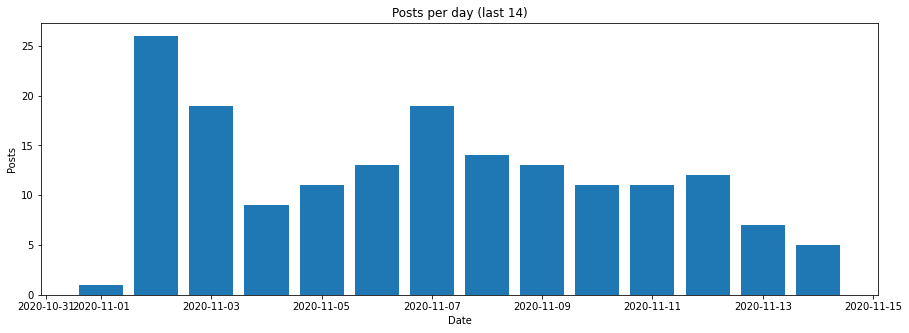

In [38]:
with get_cursor() as cur:
    cur.execute('''
        SELECT "createdAt"::DATE as date, COUNT(*) FROM "Post"
        WHERE "Post"."createdAt" > %s
        GROUP BY date
        ORDER BY date;
    ''', (NOW - TIME_PERIOD,))
    rows = cur.fetchall()

    dates, post_counts = transpose(rows)

    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,1,1)
    plt.title('Posts per day (last %d)' % TIME_PERIOD.days)
    plt.xlabel('Date')
    plt.ylabel('Posts')
    plt.bar(dates, post_counts)
    plt.show()


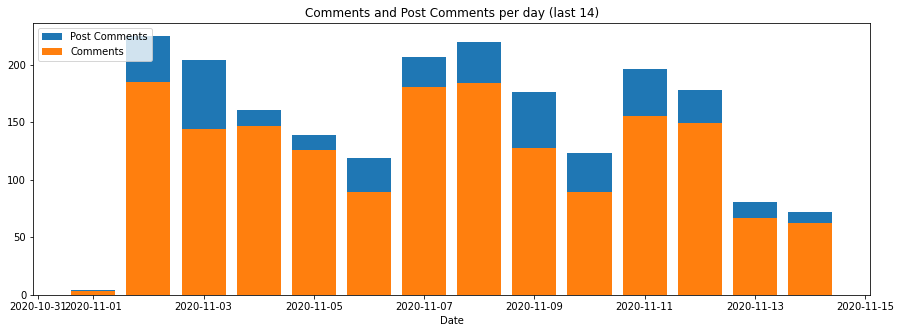

In [39]:
with get_cursor() as cur:
    cur.execute('''
        SELECT "createdAt"::DATE as date, COUNT(*) FROM "Comment"
        WHERE "Comment"."createdAt" > %s
        GROUP BY date
        ORDER BY date;
    ''', (NOW - TIME_PERIOD,))
    comment_rows = cur.fetchall()
    
    cur.execute('''
        SELECT "createdAt"::DATE as date, COUNT(*) FROM "PostComment"
        WHERE "PostComment"."createdAt" > %s
        GROUP BY date
        ORDER BY date;
    ''', (NOW - TIME_PERIOD,))
    post_comment_rows = cur.fetchall()

    dates, comment_counts, post_comment_counts = transpose(union_timeseries(comment_rows, post_comment_rows))

    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,1,1)
    
    plt.bar(dates, post_comment_counts, bottom=comment_counts, label='Post Comments')
    plt.bar(dates, comment_counts, label='Comments')
    
    plt.title('Comments and Post Comments per day (last %d)' % TIME_PERIOD.days)
    plt.xlabel('Date')
    plt.legend(loc="upper left")
    
    plt.show()

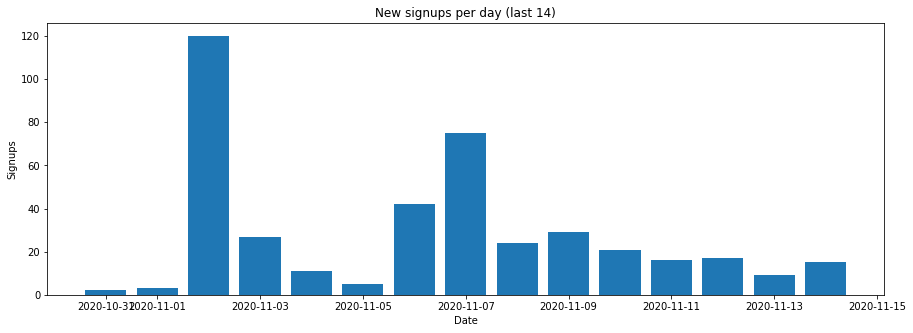

In [40]:
with get_cursor() as cur:
    cur.execute('''
        SELECT "createdAt"::DATE as date, COUNT(*) FROM "User"
        WHERE "User"."createdAt" > %s
        GROUP BY date
        ORDER BY date;
    ''', (NOW - TIME_PERIOD,))
    rows = cur.fetchall()

    dates, signup_counts = transpose(rows)

    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,1,1)
    plt.title('New signups per day (last %d)' % TIME_PERIOD.days)
    plt.xlabel('Date')
    plt.ylabel('Signups')
    plt.bar(dates, signup_counts)
    plt.show()


In [42]:
print('All times/dates are UTC unless otherwise noted.')
print('Report generated %s' % NOW.isoformat())
print('Reporting Period: %s - %s' % (
    (NOW - TIME_PERIOD).isoformat('T', 'minutes'),
    NOW.isoformat('T', 'minutes')
))

All times/dates are UTC unless otherwise noted.
Report generated 2020-11-14T19:14:43.919102
Reporting Period: 2020-10-31T19:14 - 2020-11-14T19:14
